# Times Series of Anomaly Price Detection

## Importações

In [90]:
import pandas as pd
import numpy as np
import plotly.express as px
import datetime
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure

# mostrar todas linhas e colunas
pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# 1) Leitura dos dados

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/nel-milton/Consultoria_Estatistica/main/dados_DeteccaoAnomalias.csv", sep = ";", index_col = 0, decimal = ",")

## 2) Descrição dos dados

Uma tabela simples contento algumas estatísticas sobre as variáveis numéricas

Aparentemente, os maiores valores da distribuição estão muito distantes dos quantis intervalares

In [3]:
#Análise descritiva
print(df.describe())
df.head()

       qtde_itens_vendidos  preco_venda_item
count        131921.000000     131921.000000
mean              1.198710        209.072635
std               0.845551        202.579897
min               1.000000        100.386021
25%               1.000000        124.571776
50%               1.000000        157.906881
75%               1.000000        200.349379
max              10.000000       1201.799325


,id_seller,data_inclusao_item,data_aprovacao_pedido,qtde_itens_vendidos,preco_venda_item,hora_inclusao,hora_aprovacao
1,vendedor2,2021-07-16,2021-01-16,1,103.491893,15:25:53,17:03:00
2,vendedor2,2021-07-16,2021-01-16,1,103.516297,14:52:11,17:03:00
3,vendedor2,2021-07-16,2021-01-16,1,104.070149,14:33:30,17:03:00
4,vendedor2,2021-07-16,2021-01-16,1,103.337421,15:44:41,17:03:00
5,vendedor2,2016-12-08,2021-01-16,1,102.966221,13:00:36,17:03:00


## 2.1) Tratamento de Valores Faltantes

Percebemos que existem valores faltantes em muitas datas na coluna "data_aprovacao_pedido", visto isso
esses valores nulos serão excluídos do dataset para evitar inconsistências

In [6]:
print(df.isnull().sum())
#valores faltantes em algumas colunas, serão tratadas?

id_seller                    0
data_inclusao_item           0
data_aprovacao_pedido    14025
qtde_itens_vendidos          0
preco_venda_item             0
hora_inclusao                0
hora_aprovacao           14025
preco_unitario               0
day_of_the_week              0
dtype: int64


In [7]:
df = df.dropna() #dropando valores numeros

## 2.2) Preço Unitário

Visto que existem produtos que possuem quantidade de itens superior a 1, o preço destacado entre eles não é equivalente
ao preço do produto unitário, então iremos criar uma coluna que represente o valor único do produto

In [8]:
#Analisando os dados com quantidade de itens diferente de 1

df2 = df[df['qtde_itens_vendidos'] != 1]
df2.head()

#Visto que o preço de venda do produto não equivale ao produto unitário, iremos dividir o preço de venda 
#pela quantidade de itens vendidos

df['preco_unitario'] = [preco/qtd for preco,qtd in zip(df['preco_venda_item'], df['qtde_itens_vendidos'])]
df.head()

#transformando para o formato datetime
df['data_inclusao_item'] = pd.to_datetime(df['data_inclusao_item'], format="%Y-%m-%d") 

#criando uma coluna para o dia da semana das vendas
df['day_of_the_week'] = df['data_inclusao_item'].dt.day_name()

## Feriados e Mês

In [11]:
#!pip install holidays
import holidays

br_feriados = holidays.BR() 
br_feriados

br_feriados = {datetime.date(2020, 11, 25): 'Black Friday',
               datetime.date(2021, 11, 25): 'Black Friday',
               datetime.date(2022, 11, 25): 'Black Friday'}
for date in holidays.Brazil(years=[2020,2021,2022]).items():
  br_feriados[date[0]] = date[1]


br_feriados
df['feriados'] = [br_feriados.get(i.date()) for i in df['data_inclusao_item']]

In [12]:
df['Month'] = df['data_inclusao_item'].dt.month

In [13]:
df.head()

,id_seller,data_inclusao_item,data_aprovacao_pedido,qtde_itens_vendidos,preco_venda_item,hora_inclusao,hora_aprovacao,preco_unitario,day_of_the_week,feriados,Month
1,vendedor2,2021-07-16,2021-01-16,1,103.491893,15:25:53,17:03:00,103.491893,Friday,None,7
2,vendedor2,2021-07-16,2021-01-16,1,103.516297,14:52:11,17:03:00,103.516297,Friday,None,7
3,vendedor2,2021-07-16,2021-01-16,1,104.070149,14:33:30,17:03:00,104.070149,Friday,None,7
4,vendedor2,2021-07-16,2021-01-16,1,103.337421,15:44:41,17:03:00,103.337421,Friday,None,7
5,vendedor2,2016-12-08,2021-01-16,1,102.966221,13:00:36,17:03:00,102.966221,Thursday,None,12


## 2.3) Gráficos

O gráfico abaixo representa o preço comparado entre todos os vendedores ao longo do período disponível, já conseguimos
ter uma noção (em um contexto geral) do que pode ou não pode ser anomalia

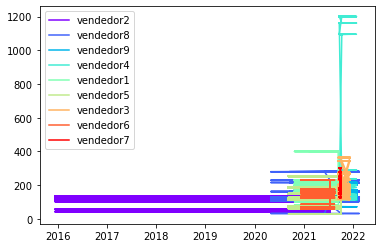

In [49]:
colors = cm.rainbow(np.linspace(0, 1, len(df['id_seller'].unique())))


for i,c in zip(df['id_seller'].unique(),colors):
    df_aux = df[df['id_seller'] == i]
    plt.plot(df_aux['data_inclusao_item'],df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

Os preços do vendedor 4 estão muito acima dos demais, estes são os valores máximos vistos na tabela descritiva (item 2)

Nesse gráfico geral, percebemos que o vendedor 2 está presente em um período de tempo muito maior que os demais

In [50]:
print(df.groupby(by = 'id_seller')['data_inclusao_item'].min())
print(df.groupby(by = 'id_seller').size())

#com exceção do vendedor 2, os outros vendedores publicaram esses produtos em torno de 2020/2021
#a abordagem poderá filtrar esse período 

id_seller
vendedor1   2020-10-24
vendedor2   2015-12-08
vendedor3   2021-09-13
vendedor4   2021-09-22
vendedor5   2020-09-09
vendedor6   2020-12-11
vendedor7   2021-09-23
vendedor8   2020-05-01
vendedor9   2021-07-24
Name: data_inclusao_item, dtype: datetime64[ns]
id_seller
vendedor1    11070
vendedor2    11913
vendedor3    13872
vendedor4    13110
vendedor5    14212
vendedor6    13125
vendedor7    14940
vendedor8    12160
vendedor9    13494
dtype: int64


Os outros vendedores tem sua data mínima de produtos presente no período entre 2020 e 2021, enquanto o vendedor 2 apresenta período inicial em 2015, será algo a ser considerado futuramente

In [51]:
df_split = df[df['data_inclusao_item'] >= '2020-01-01']
print(df_split.groupby(by = 'id_seller')['data_inclusao_item'].min())
print(df_split.groupby(by = 'id_seller').size())

#A perda de amostras não é tão significativa para o vendedor 2 em dados anteriores a 2020

id_seller
vendedor1   2020-10-24
vendedor2   2021-07-16
vendedor3   2021-09-13
vendedor4   2021-09-22
vendedor5   2020-09-09
vendedor6   2020-12-11
vendedor7   2021-09-23
vendedor8   2020-05-01
vendedor9   2021-07-24
Name: data_inclusao_item, dtype: datetime64[ns]
id_seller
vendedor1    11070
vendedor2     9999
vendedor3    13872
vendedor4    13110
vendedor5    14212
vendedor6    13125
vendedor7    14940
vendedor8    12160
vendedor9    13494
dtype: int64


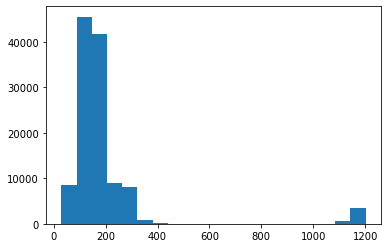

In [29]:
#Histograma de frequencia
fig3 = plt.hist(df['preco_unitario'], bins = 20)

#O preço mais frequente publicado está em torno de 200 reais

### Relação Frequência x Dia da Semana

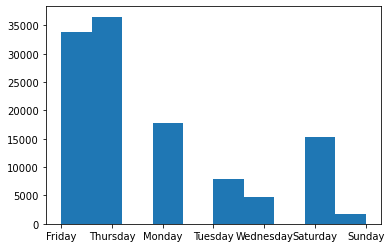

In [43]:
#Histograma de frequencia
fig4 = plt.hist(df['day_of_the_week'], bins = 10)

Aparentemente, o número de vendas é mais frequente na quinta e na sexta-feira. Pode afetar na precificação?

# 3) Aplicando a Abordagem Kmeans

Através da curva de elbow, vamos descobrir qual valor de k é mais explicativo para nosso modelo 

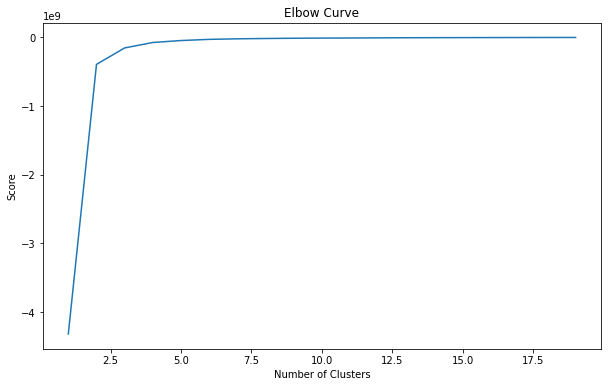

In [44]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']

data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()

n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data2) for i in n_cluster]
scores = [kmeans[i].score(data2) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#k_ideal = 3

## 3.1) Abordagem Geral

Considerando todo o período disponível, utilizaremos nessa etapa apenas o preço unitário como variável para 
detectar as anomalias

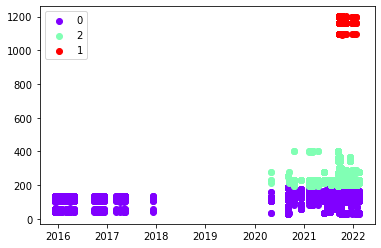

In [92]:
data = df[['preco_unitario']]

km = KMeans(n_clusters = 3)
km.fit(data)
y_km = km.predict(data)

data['Anomaly'] = y_km
data['Anomaly'] = data['Anomaly'].astype(str)

data['Date'] = df['data_inclusao_item']
data['Vendedor'] = df['id_seller']
data.head()


colors = cm.rainbow(np.linspace(0, 1, len(data['Anomaly'].unique())))

for i,c in zip(data['Anomaly'].unique(),colors):
    df_aux = data[data['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

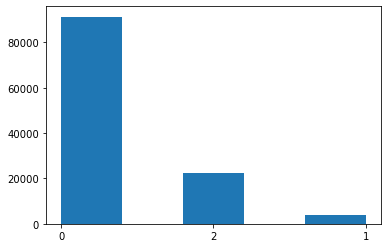

In [56]:
fig = plt.hist(data['Anomaly'], bins = 5)

## Abordagem 2)  - Filtrando os dados após 2020

## Inserindo Dia da Semana, Mês, Feriados

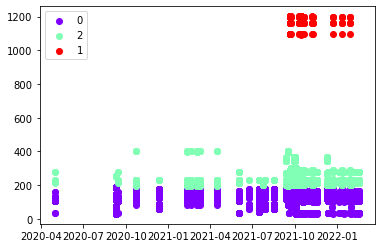

In [67]:
#transformando variáveis categóricas

df1 = df[df['data_inclusao_item'] >= '2020-01-01']

data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

## Teste de Comparação Múltipla de Médias 

Agora, como próximo passo, precisaremos utilizar um teste de comparação múltipla de médias
para ver se as médias possuem diferenças estatísticamente significativas, para isso, utilizaremos o teste de tukey comparando em nossos 3 grupos de anomalias (0,1,2). Antes, precisamos conferir se os dados assumem as pressuposições básicas (Normalidade e Homogeneidade de Variância)

In [68]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro

####### Iremos Calcular a Normalidade dentro dos Grupos

zero = data2[data2['Anomaly'] == '0']['preco_unitario']
um = data2[data2['Anomaly'] == '1']['preco_unitario']
dois = data2[data2['Anomaly'] == '2']['preco_unitario']


print(shapiro(zero))
print(shapiro(um))
print(shapiro(dois))


print(f_oneway(zero, um, dois))

tukey = pairwise_tukeyhsd(endog=data2['preco_unitario'],
                          groups=data2['Anomaly'],
                          alpha=0.05)

#display results
print(tukey)

ShapiroResult(statistic=0.9376081228256226, pvalue=0.0)
ShapiroResult(statistic=0.755314826965332, pvalue=0.0)
ShapiroResult(statistic=0.9219351410865784, pvalue=0.0)
F_onewayResult(statistic=1569808.9618476592, pvalue=0.0)
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     0      1 1032.6749 0.001 1031.2935 1034.0562   True
     0      2  115.3742 0.001   114.738  116.0104   True
     1      2 -917.3007 0.001 -918.7669 -915.8345   True
--------------------------------------------------------


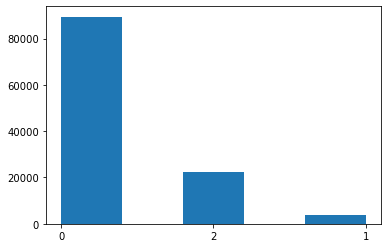

In [69]:
fig = plt.hist(data2['Anomaly'], bins = 5)

# Análise IntraVendedores

Como estamos usando 3 clusters em nosso modelo, é mais difícil identificar onde a anomalia está presente dependendo do vendedor, então abaixo do nosso gráfico, plotaremos um histograma de frequencia dos clusters apresentados [0,1,2], no qual consideraremos o cluster com maior frequência o preço "normal", e os restantes como anomalias.


## Vendedor 1

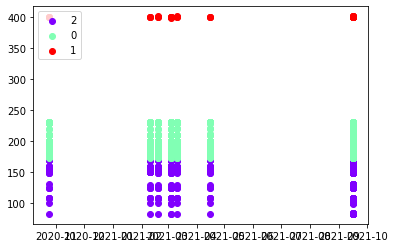

In [70]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor1']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

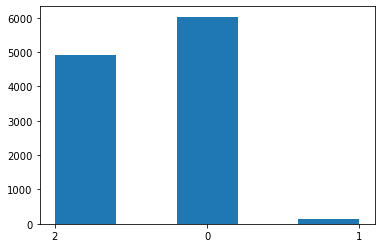

In [71]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 2

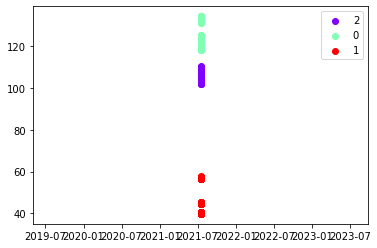

In [72]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor2']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

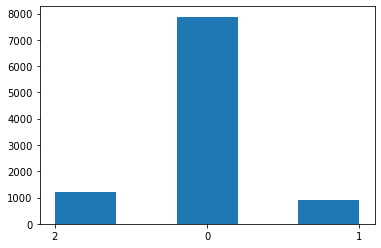

In [73]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 3

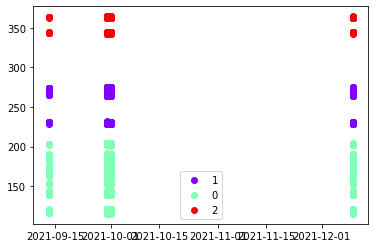

In [74]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor3']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

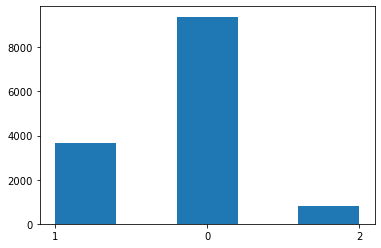

In [75]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 4

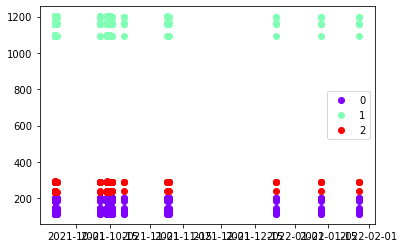

In [76]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor4']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

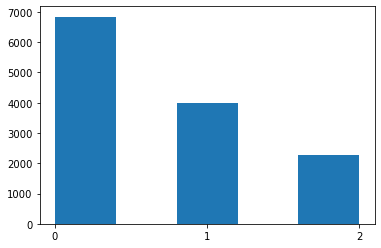

In [77]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 5

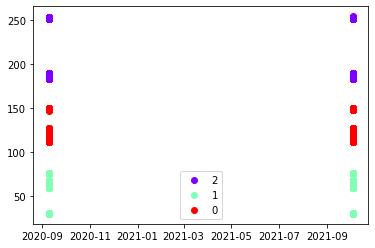

In [78]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor5']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

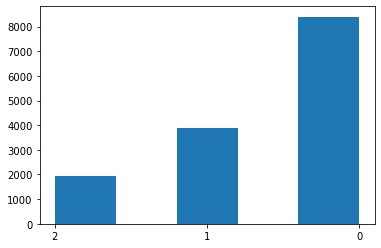

In [80]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 6

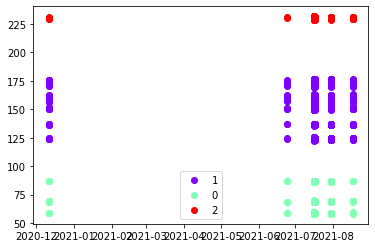

In [81]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor6']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

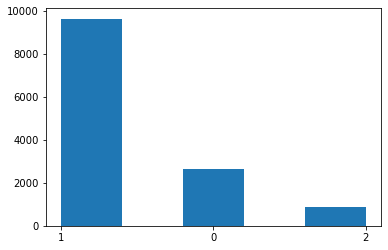

In [82]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 7

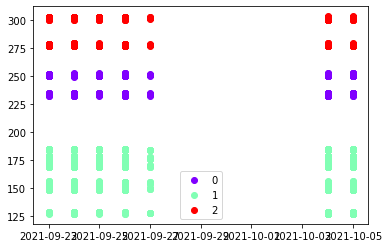

In [83]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor7']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

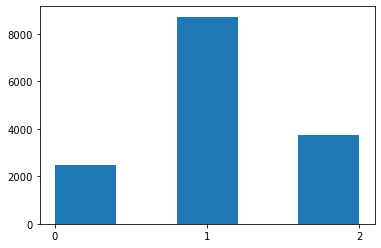

In [84]:
fig = plt.hist(data2['Anomaly'], bins = 5)

## Vendedor 8

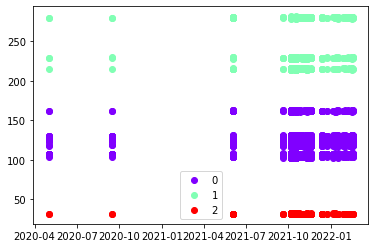

In [85]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor8']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

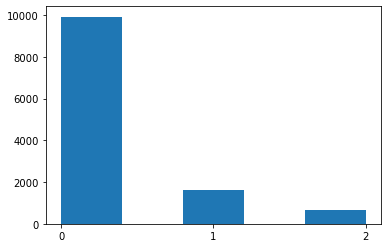

In [86]:
fig = plt.hist(data2['Anomaly'], bins = 5)

##  Vendedor 9

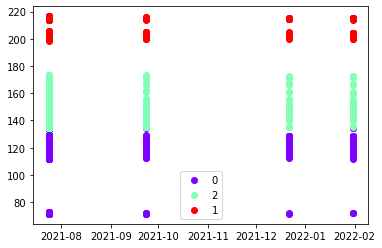

In [87]:
df1 = df[df['data_inclusao_item'] >= '2020-01-01']
df1 = df1[df1['id_seller'] == 'vendedor9']


data2 = df1[['preco_unitario', 'day_of_the_week', 'Month' , 'feriados']]
data2 = pd.get_dummies(data2, columns = ['day_of_the_week', 'Month', 'feriados'])
data2.head()


km = KMeans(n_clusters = 3)
km.fit(data2)
y_km2 = km.predict(data2)

data2['Anomaly'] = y_km2
data2['Anomaly'] = data2['Anomaly'].astype(str)

data2['Date'] = df1['data_inclusao_item']
data2['Vendedor'] = df1['id_seller']


colors = cm.rainbow(np.linspace(0, 1, len(data2['Anomaly'].unique())))

for i,c in zip(data2['Anomaly'].unique(),colors):
    df_aux = data2[data2['Anomaly'] == i]
    plt.scatter(df_aux['Date'], df_aux['preco_unitario'], color = c, label = i)
    plt.legend()

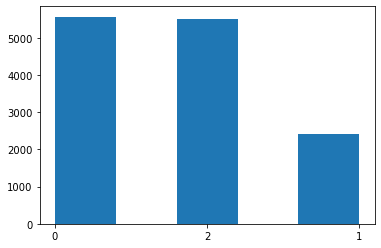

In [88]:
fig = plt.hist(data2['Anomaly'], bins = 5)